In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from timezonefinder import TimezoneFinder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)

In [3]:
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

In [4]:
from abc import ABC
from abc import abstractmethod

In [5]:
from copy import copy, deepcopy

# Constants

In [6]:
PROJECT_PATH = Path.cwd()
DATA_PATH = PROJECT_PATH / "data"
TESLA_PATH = DATA_PATH / "tesla_21-23.csv"

LATITUDE_pxm = 51.381
LONGITUDE_pxm = 0.522
TIMEZONE_pxm = TimezoneFinder().certain_timezone_at(lat=LATITUDE_pxm, lng=LONGITUDE_pxm)

...

Ellipsis

In [7]:
FEATURES = ["timestamp", "grid_power", "battery_soc", "battery_power", "load_power", "solar_power"]

# Utilities

In [8]:
def plot_corr(df):
    for i, method in enumerate(("pearson", "spearman")):
        corr_mat = df.corr(method=method)
        mask = np.zeros_like(corr_mat, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=(20, 10))
        sns.heatmap(
            data=corr_mat,
            mask=mask,
            annot=True,
            fmt='.2f',
            vmax=1,
            center=0,
            square=True,
            linewidth=.5,
            cbar_kws={'shrink': .5},
        )
        plt.title(method)

def show_info(df: pd.DataFrame):
    print(df.head())
    print(df.info())
    df.hist(figsize=(15, 15))
    plot_corr(df)

In [9]:
...

Ellipsis

# Preprocessing and Analysis

In [10]:
tesla_df = pd.read_csv(TESLA_PATH)

In [11]:
tesla_df = tesla_df[FEATURES]

In [12]:
tesla_df["timestamp"] = pd.to_datetime(tesla_df["timestamp"], utc=False)
tesla_df = tesla_df.assign(timestamp=tesla_df.timestamp.dt.tz_convert(TIMEZONE_pxm))

In [13]:
tesla_df = tesla_df.set_index("timestamp")

                           grid_power  battery_soc  battery_power  load_power  \
timestamp                                                                       
2021-10-31 21:00:00+00:00     108.528        8.918       1120.558    1220.084   
2021-10-31 22:00:00+00:00    1323.152        7.004       -121.634    1192.040   
2021-10-31 23:00:00+00:00    1029.242        7.225       -125.408     894.638   
2021-11-01 00:00:00+00:00    2389.552        7.451       -124.011    2255.193   
2021-11-01 01:00:00+00:00     804.145        7.676       -124.676     669.420   

                           solar_power  
timestamp                               
2021-10-31 21:00:00+00:00       -9.759  
2021-10-31 22:00:00+00:00       -9.508  
2021-10-31 23:00:00+00:00       -9.534  
2021-11-01 00:00:00+00:00       -9.772  
2021-11-01 01:00:00+00:00       -9.963  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15142 entries, 2021-10-31 21:00:00+00:00 to 2023-07-31 21:00:00+01:00
Data columns (total 5 

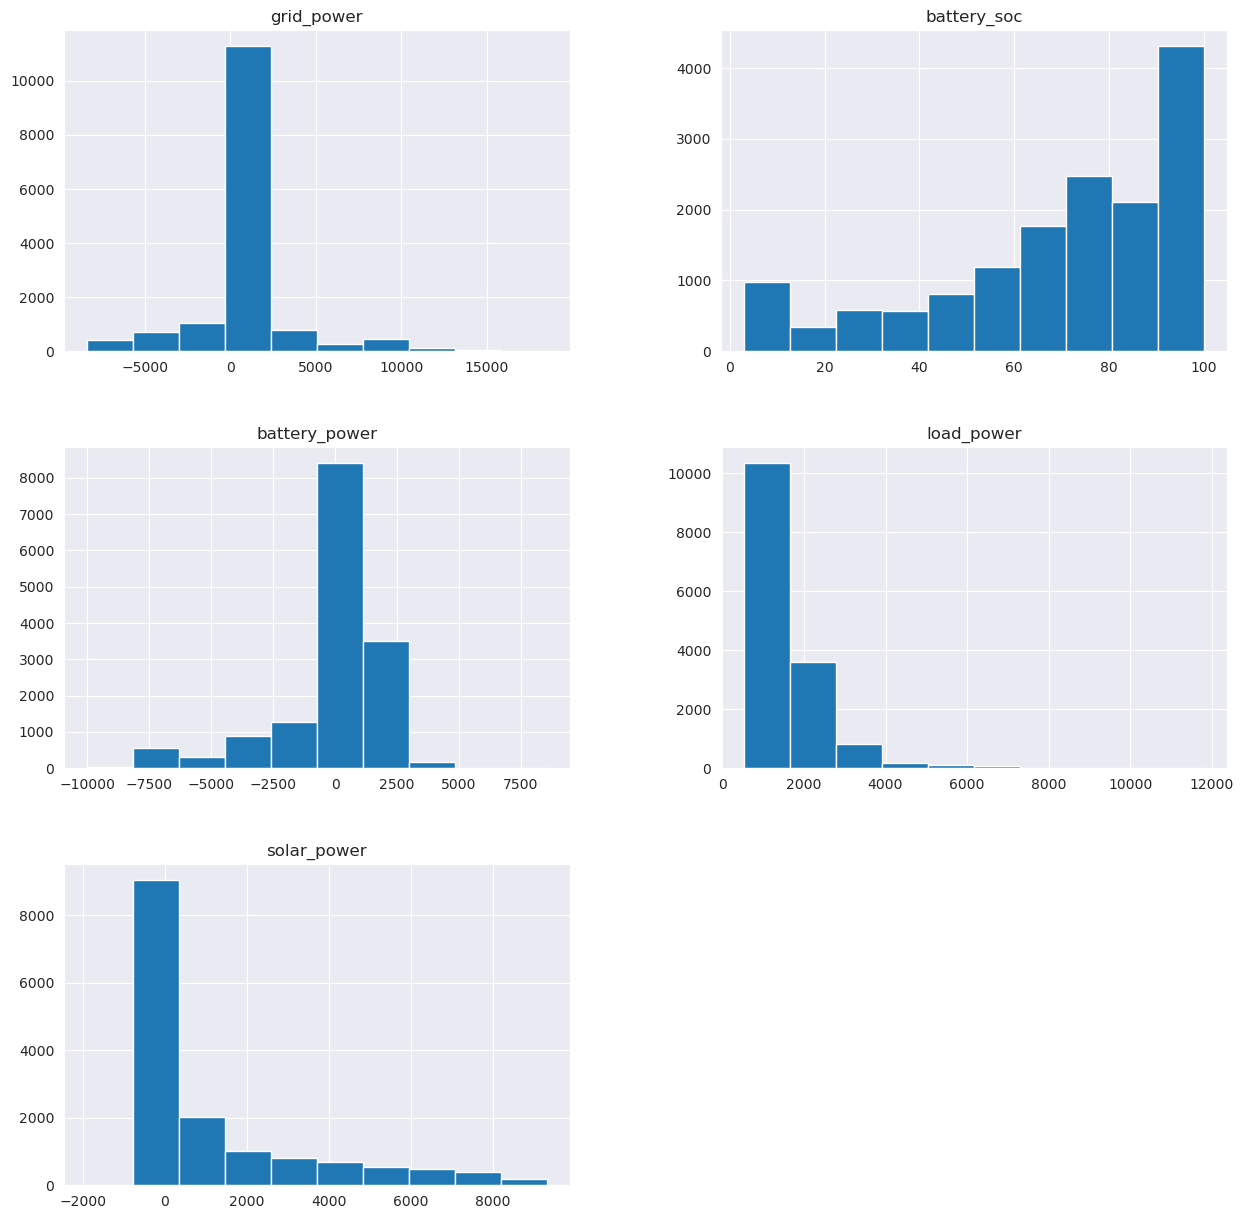

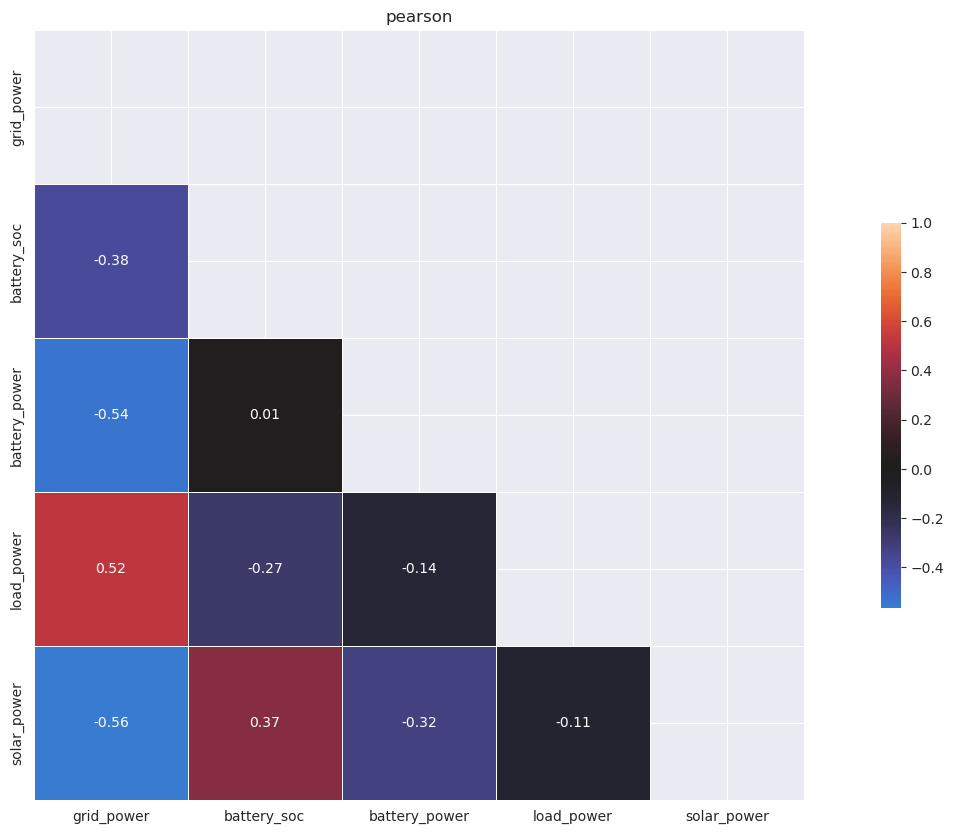

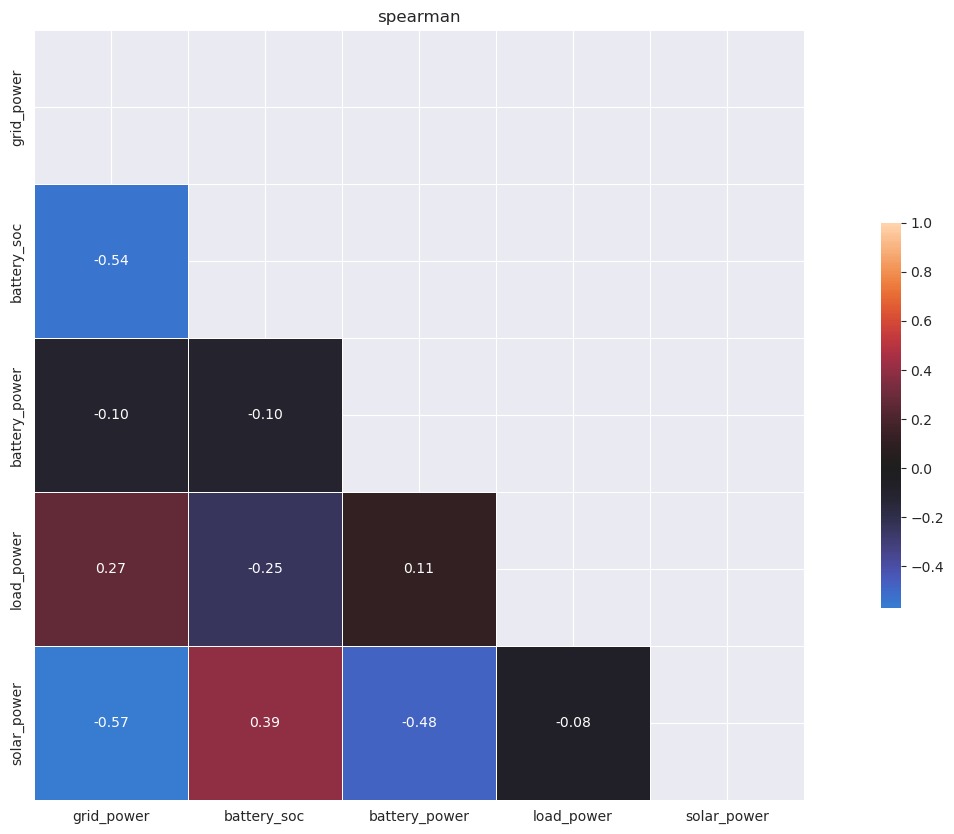

In [14]:
show_info(tesla_df)

In [15]:
load_df = tesla_df["load_power"]

In [16]:
split_timestamp = pd.Timestamp(year=2022, month=8, day=1, tz=TIMEZONE_pxm)

In [17]:
load_df_test = load_df[load_df.index >= split_timestamp]

In [18]:
load_df_train = load_df.loc[load_df.index < split_timestamp]

In [19]:
FORECAST_LENGTH = 6
HISTORY_LENGTH = 24

In [20]:
class TimeSeriesModel(ABC):
    
    @abstractmethod
    def forecast(self, history: pd.DataFrame) -> np.ndarray:
        ...
    
...

Ellipsis

In [21]:
class LoadModelMean(TimeSeriesModel):
    def __init__(self, forecast_length: int):
        self.forecast_length = forecast_length
    
    def forecast(self, history: pd.DataFrame) -> np.ndarray:
        return np.mean(history.values) * np.ones(self.forecast_length)

In [22]:
def get_history(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    return timeseries[timestamp - pd.Timedelta(f"{hours_n}:00:00"): timestamp - pd.Timedelta("1:00:00")]

In [23]:
def get_actual_forecast(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    return timeseries[timestamp : timestamp  + pd.Timedelta(f"{hours_n-1}:00:00")]

In [24]:
def model_testing_on_timestamp(model: TimeSeriesModel, timeseries: pd.DataFrame, timestamp: pd.Timestamp):
    history = get_history(timeseries, timestamp, HISTORY_LENGTH)
    actual_forecast = get_actual_forecast(timeseries, timestamp, FORECAST_LENGTH)
    forecast = model.forecast(history)
    
    merged_data = pd.merge(history, history, left_index=True, right_index=True)
    merged_data = merged_data.rename(columns={'load_power_x': 'actual', 'load_power_y': 'model'})
    merged_data["error"] = np.zeros(len(history))
    
    merged_data_next = pd.DataFrame(actual_forecast)
    merged_data_next = merged_data_next.rename(columns={'load_power': 'actual'})
    merged_data_next["model"] = forecast
    merged_data_next["error"] = merged_data_next["actual"]- merged_data_next["model"]
    
    result_df = pd.concat([merged_data, merged_data_next])
    
    return result_df

<Axes: xlabel='timestamp'>

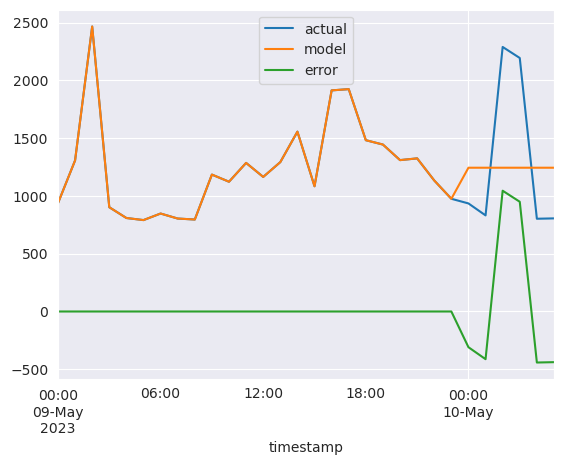

In [25]:
result_df = model_testing_on_timestamp(LoadModelMean(FORECAST_LENGTH), 
                                       load_df_test, pd.Timestamp(year=2023, month=5, day=10, tz=TIMEZONE_pxm))
result_df.plot()

<Axes: xlabel='timestamp'>

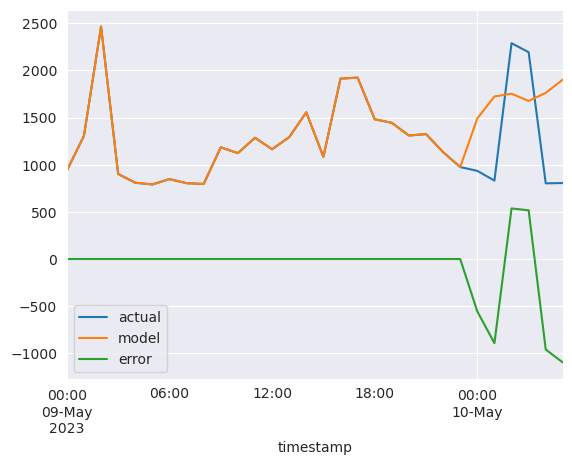

In [43]:
result_df = model_testing_on_timestamp(LoadModelFEDOT(FORECAST_LENGTH), 
                                       load_df_test, pd.Timestamp(year=2023, month=5, day=10, tz=TIMEZONE_pxm))
result_df.plot()

In [42]:
class LoadModelFEDOT(TimeSeriesModel):
    def __init__(self, forecast_length: int):
        self.forecast_length = forecast_length
    
    def forecast(self, history: pd.DataFrame) -> np.ndarray:
        return model.forecast(pre_history=history.values)

# FEDOT

In [26]:
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=FORECAST_LENGTH))

In [27]:
load_df_train.to_csv(f"{DATA_PATH }/load_df_train.csv")

In [28]:
train_input = InputData.from_csv_time_series(task=task,
                                             file_path=f"{DATA_PATH }/load_df_train.csv",
                                             delimiter=',',
                                             target_column='load_power')

2023-08-11 16:52:53,668 - CSV data extraction - Used the column as index: "timestamp".


In [29]:
# split data for train and test
train_data, test_data = train_test_data_setup(train_input, split_ratio=0.99)

In [30]:
# init model for the time-series forecasting
model = Fedot(problem='ts_forecasting', task_params=task.task_params)

In [31]:
# run AutoML model design
pipeline = model.fit(train_data)

/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_squared link alias is deprecated. Use

2023-08-11 16:53:50,967 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 21.5 MiB, max: 25.4 MiB
2023-08-11 16:53:50,970 - ApiComposer - Initial pipeline was fitted in 37.9 sec.
2023-08-11 16:53:50,973 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2023-08-11 16:53:50,999 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 5.0 min. Set of candidate models: ['cut', 'sparse_lagged', 'diff_filter', 'glm', 'lasso', 'dtreg', 'ar', 'rfr', 'gaussian_filter', 'pca', 'ransac_non_lin_reg', 'normalization', 'scaling', 'ransac_lin_reg', 'linear', 'polyfit', 'sgdr', 'smoothing', 'ts_naive_average', 'lagged', 'adareg', 'locf', 'ridge', 'ets'].
2023-08-11 16:53:51,008 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWar

2023-08-11 16:54:04,996 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_squared link alias is deprecated. Use

2023-08-11 16:54:49,109 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-08-11 16:55:40,652 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-08-11 16:56:17,236 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-08-11 16:56:52,074 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-08-11 16:57:52,511 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-08-11 16:58:59,693 - MultiprocessingDispatcher - 32 individuals out of 54 in previous population were evaluated successfully.
2023-08-11 16:58:59,944 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [05:08<?, ?gen/s]


2023-08-11 16:59:00,210 - ApiComposer - Model generation finished
2023-08-11 16:59:56,715 - FEDOT logger - Final pipeline was fitted
2023-08-11 16:59:56,719 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, glm, adareg, lagged]}
ridge - {}
glm - {'family': 'gaussian', 'link': 'identity'}
adareg - {}
lagged - {'window_size': 10.884963342081727}
2023-08-11 16:59:56,721 - MemoryAnalytics - Memory consumption for finish in main session: current 24.1 MiB, max: 34.1 MiB


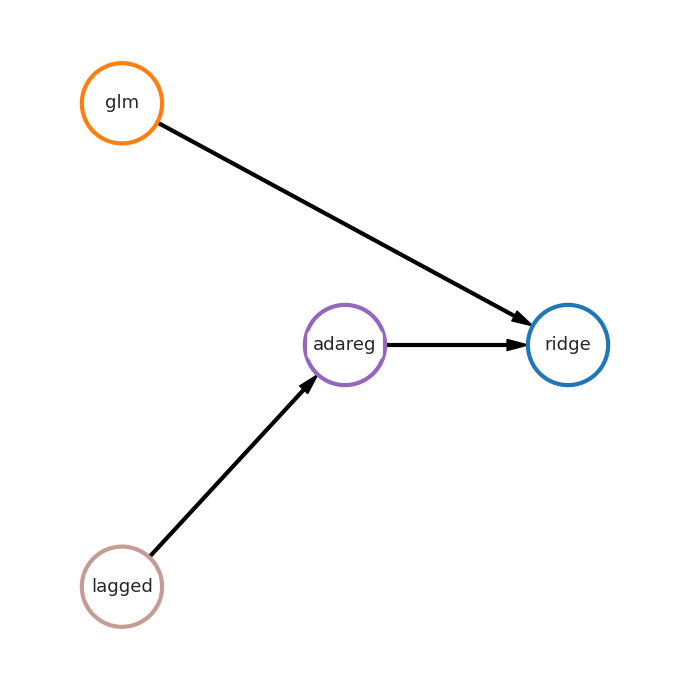

In [32]:
pipeline.show()

In [33]:
forecast = model.forecast(test_data)
print(model.get_metrics(metric_names=['rmse', 'mae', 'mape'], target=test_data.target))

{'rmse': 136.721, 'mae': 123.24, 'mape': 0.098}


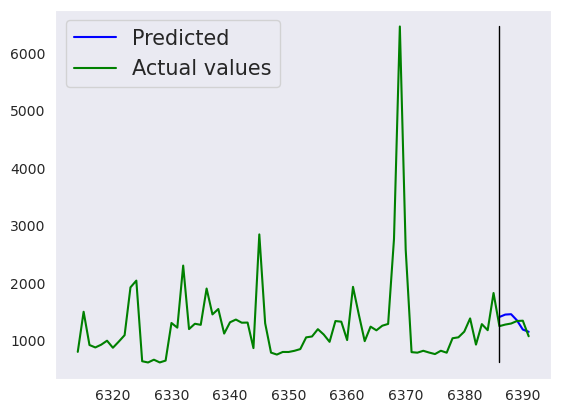

In [34]:
model.plot_prediction()

In [ ]:
model.forecast(pre_history=history)

In [38]:
history_ = get_history(load_df_train, pd.Timestamp(year=2022, month=4, day=4, hour=12, tz=TIMEZONE_pxm), 24)

In [41]:
model.forecast(pre_history=history_.values)

array([2643.01577582, 2325.04387306, 2127.77900746, 1968.43119794,
       1910.74191059, 1942.54463356])

In [35]:
import pickle

In [36]:
with open("model_fedot_0.pkl", "wb") as model_file:
    pickle.dump(model, model_file)